In [61]:
import os
import datasets
import transformers
import torch
from datasets import load_dataset
from datasets import DatasetDict, Dataset
from sklearn.model_selection import train_test_split

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [63]:
datasets.__version__, transformers.__version__, torch.__version__

('3.3.2', '4.49.0', '2.5.1')

# 1. Loading Dataset
Source: https://huggingface.co/nicholasKluge/ToxicityModel

In [64]:
ds = load_dataset("nicholasKluge/toxic-text")
ds

DatasetDict({
    portuguese: Dataset({
        features: ['non_toxic', 'toxic'],
        num_rows: 28103
    })
    english: Dataset({
        features: ['non_toxic', 'toxic'],
        num_rows: 41843
    })
})

In [65]:
# taking only the english dataset
ds = DatasetDict({
    "english": ds["english"]
})
ds

DatasetDict({
    english: Dataset({
        features: ['non_toxic', 'toxic'],
        num_rows: 41843
    })
})

In [66]:
# placing every sentence into text and applying respective labels
def preprocess(batch):
    texts = []
    labels = []
    
    for non_toxic, toxic in zip(batch["non_toxic"], batch["toxic"]):
        if non_toxic:
            texts.append(non_toxic)
            labels.append('non_toxic')
        if toxic: 
            texts.append(toxic)
            labels.append('toxic')

    return {"text": texts, "label": labels}

processed_ds = ds["english"].map(preprocess, batched=True, remove_columns=["non_toxic", "toxic"])

In [67]:
processed_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 83686
})

In [68]:
processed_ds['text'][0], processed_ds['label'][0]

("Can you tell me how to keep my email password safe from being posted to the darkweb? Is this related to something you heard about recently? I'm guessing you mean that you're worried someone might get access to your email account and then find the password in there, or maybe intercept you while you're typing in your password, so that you can read it somehow. It's not really possible to keep passwords 100 % Thanks for the information. How do scammers find my email password on the darkweb? I'm confused by what you mean by “ darkweb ” and why you're asking me about this. It seems like you're saying that you know there's some type of site where scammers find email passwords? Yeah, do you know which websites scammer use to find people's email passwords? You mean to ask me whether there are any places online where someone can search to see email passwords?",
 'non_toxic')

In [69]:
processed_ds['text'][1], processed_ds['label'][1]

('Jenner has not been shy to offer her opinion on Hillary on the likely - to - be - cancelled I Am Cait, calling the candidate a “ fucking liar ” and a “ lousy senator. ”',
 'toxic')

In [70]:
df = processed_ds.to_pandas()

# train (80%) and test+validation (20%) with stratification
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# test+validation into validation (50%) and test (50%) with stratification
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

train_ds = Dataset.from_pandas(train_df).remove_columns(['__index_level_0__'])
valid_ds = Dataset.from_pandas(valid_df).remove_columns(['__index_level_0__'])
test_ds = Dataset.from_pandas(test_df).remove_columns(['__index_level_0__'])

final_ds = DatasetDict({
    "train": train_ds,
    "validation": valid_ds,
    "test": test_ds
})

In [71]:
final_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 66948
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 8369
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 8369
    })
})

In [72]:
label2id = {'non_toxic': 0, 'toxic': 1}
id2label = {0: 'non_toxic', 1: 'toxic'}

# 2. Model and Tokenization

In [73]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

In [74]:
NUM_LABELS = len(label2id)

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = NUM_LABELS,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# 3. Preprocessing

In [75]:
def tokenize_function(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

# Apply tokenization to train, validation, and test datasets
tokenized_ds = final_ds.map(tokenize_function, batched=True, remove_columns=["text"])

Map: 100%|██████████| 8369/8369 [00:00<00:00, 17420.71 examples/s]


In [76]:
# Apply label mapping
def map_labels(batch):
    batch['label'] = [label2id[label] for label in batch['label']]
    return batch

# Apply label mapping to dataset
tokenized_ds = tokenized_ds.map(map_labels, batched=True)

Map: 100%|██████████| 8369/8369 [00:00<00:00, 603005.05 examples/s]


In [77]:
tokenized_ds.set_format("torch")

In [78]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 66948
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8369
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8369
    })
})

In [79]:
tokenized_ds['train'][0]['input_ids'].shape

torch.Size([128])

In [80]:
tokenizer.decode(tokenized_ds['train'][0]['input_ids'])

'[CLS] fuck asshole fuck dirty fuckin asshole fuckin scum [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [81]:
tokenized_ds["train"]["label"]

tensor([1, 0, 1,  ..., 0, 1, 0])

# 4. Preparing dataloader

In [82]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [83]:
small_train_dataset = tokenized_ds["train"].shuffle(seed=SEED).select(range(10000))
small_eval_dataset = tokenized_ds["validation"].shuffle(seed=SEED).select(range(1000))
small_test_dataset = tokenized_ds["test"].shuffle(seed=SEED).select(range(1000))

In [84]:
from torch.utils.data import DataLoader

In [85]:
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [86]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128]))

# 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [87]:
teacher_model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "non_toxic",
    "1": "toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "non_toxic": 0,
    "toxic": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [88]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()

In [89]:
# Creating configurations
configuration_even = configuration.copy()
configuration_even['num_hidden_layers'] //= 2

configuration_odd = configuration.copy()
configuration_odd['num_hidden_layers'] //= 2

# Convert to BertConfig
configuration_even = BertConfig.from_dict(configuration_even)
configuration_odd = BertConfig.from_dict(configuration_odd)

In [90]:
model_even = type(teacher_model)(configuration_even)
model_even

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [91]:
model_odd = type(teacher_model)(configuration_odd)
model_odd

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [92]:
# indexing starts from 0 :- so 0 to 11
# 1st layer = 0, 2nd layer = 1, ..., 12th layer = 11

# Intuition:
# [first, second, third, fourth, fifth, sixth, seventh, eight, ninth, tenth, eleventh, twelfth]
# [0    ,    1,      2,    3,      4,      5,      6,     7,     8,     9,     10,       11]

from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights_odd_layers(
    teacher : Module,
    student : Module,
) -> None:
    """
    Recursively copies the odd weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_odd_layers(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        for i in range(len(student_encoding_layers)):
            # getting even-indexed layers but the position is odd
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return student

In [93]:
def distill_bert_weights_even_layers(
    teacher : Module,
    student : Module,
) -> None:
    """
    Recursively copies the even weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_even_layers(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        for i in range(len(student_encoding_layers)):
            # getting odd-indexed layers but the position is even
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i + 1].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return student

In [94]:
# Distill even layers (2, 4, 6, 8, 10, 12) -> [1, 3, 5, 7, 9, 11] in 0-based indexing
model_even = distill_bert_weights_even_layers(teacher = teacher_model, student = model_even)

# Distill odd layers (1, 3, 5, 7, 9, 11) -> [0, 2, 4, 6, 8, 10] in 0-based indexing
model_odd = distill_bert_weights_odd_layers(teacher = teacher_model, student = model_odd)


In [95]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model_even))

Teacher parameters : 109483778
Student parameters : 66956546


In [96]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model_odd))

Teacher parameters : 109483778
Student parameters : 66956546


In [97]:
print(f"even: {count_parameters(model_even)/count_parameters(teacher_model) * 100:.2f}%")
print(f"odd: {count_parameters(model_odd)/count_parameters(teacher_model) * 100:.2f}%")

even: 61.16%
odd: 61.16%


### 5.2 Loss function

In [98]:
import torch.nn.functional as F
import torch.nn as nn

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [99]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

# 6. Optimizer

In [100]:
import torch.optim as optim

lr = 5e-5

#training hyperparameters
optimizer_even = optim.Adam(params=model_even.parameters(), lr=lr)
optimizer_odd = optim.Adam(params=model_odd.parameters(), lr=lr)

In [101]:
model_even = model_even.to(device)
model_odd = model_odd.to(device)
teacher_model = teacher_model.to(device)

# 7. Learning Rate Scheduler

In [102]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler_even = get_scheduler(
    name="linear", 
    optimizer=optimizer_even, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

lr_scheduler_odd = get_scheduler(
    name="linear", 
    optimizer=optimizer_odd, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

# 8. Metric

In [103]:
import numpy as np
import evaluate

# Get the metric function
metric = evaluate.load("accuracy")

# 9. Train

## 9.1 Even

In [104]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

  0%|          | 0/1565 [00:00<?, ?it/s]

In [105]:
# Lists to store losses for each epoch
train_losses_even = []
train_losses_cls_even = []
train_losses_div_even = []
train_losses_cos_even = []
eval_losses_even = []

for epoch in range(num_epochs):
    model_even.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model_even(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_even.step()
        lr_scheduler_even.step()
        optimizer_even.zero_grad()
        progress_bar.update(1)
        
    train_losses_even.append(train_loss / len(train_dataloader))
    train_losses_cls_even.append(train_loss_cls / len(train_dataloader))
    train_losses_div_even.append(train_loss_div / len(train_dataloader))
    train_losses_cos_even.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
    
    model_even.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model_even(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses_even.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

 20%|██        | 313/1565 [01:22<04:28,  4.67it/s]

Epoch at 1: Train loss 0.2000:
  - Loss_cls: 0.4414
  - Loss_div: 0.0902
  - Loss_cos: 0.0684
Epoch at 1: Test Acc 0.9230


 40%|███▉      | 625/1565 [02:46<04:05,  3.83it/s]

Epoch at 2: Train loss 0.1787:
  - Loss_cls: 0.3533
  - Loss_div: 0.1217
  - Loss_cos: 0.0611
Epoch at 2: Test Acc 0.9340


 60%|█████▉    | 938/1565 [04:09<02:44,  3.82it/s]

Epoch at 3: Train loss 0.1710:
  - Loss_cls: 0.3244
  - Loss_div: 0.1318
  - Loss_cos: 0.0567
Epoch at 3: Test Acc 0.9470


 80%|███████▉  | 1251/1565 [05:33<01:21,  3.83it/s]

Epoch at 4: Train loss 0.1675:
  - Loss_cls: 0.3132
  - Loss_div: 0.1354
  - Loss_cos: 0.0538
Epoch at 4: Test Acc 0.9450


100%|█████████▉| 1564/1565 [06:57<00:00,  3.82it/s]

Epoch at 5: Train loss 0.1657:
  - Loss_cls: 0.3098
  - Loss_div: 0.1364
  - Loss_cos: 0.0510
Epoch at 5: Test Acc 0.9450
Avg Metric 0.9388


In [106]:
import matplotlib.pyplot as plt

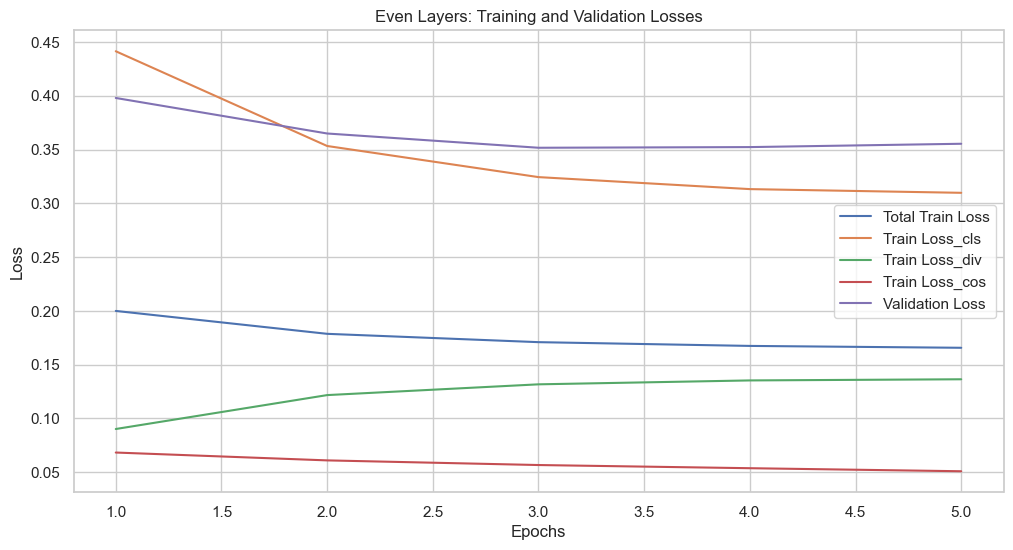

In [107]:
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_even, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_even, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_even, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_even, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_even, label='Validation Loss')

plt.title('Even Layers: Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [108]:
from tqdm.auto import tqdm
progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

100%|██████████| 1565/1565 [06:59<00:00,  3.73it/s]


## 9.2 Odd

In [109]:
# Lists to store losses for each epoch
train_losses_odd = []
train_losses_cls_odd = []
train_losses_div_odd = []
train_losses_cos_odd = []
eval_losses_odd = []

for epoch in range(num_epochs):
    model_odd.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model_odd(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_odd.step()
        lr_scheduler_odd.step()
        optimizer_odd.zero_grad()
        progress_bar.update(1)
        
    train_losses_odd.append(train_loss / len(train_dataloader))
    train_losses_cls_odd.append(train_loss_cls / len(train_dataloader))
    train_losses_div_odd.append(train_loss_div / len(train_dataloader))
    train_losses_cos_odd.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
    
    model_odd.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model_odd(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses_odd.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

Epoch at 1: Train loss 0.2008:
  - Loss_cls: 0.4406
  - Loss_div: 0.0926
  - Loss_cos: 0.0692
Epoch at 1: Test Acc 0.9350


Epoch at 2: Train loss 0.1795:
  - Loss_cls: 0.3538
  - Loss_div: 0.1237
  - Loss_cos: 0.0609
Epoch at 2: Test Acc 0.9440


Epoch at 3: Train loss 0.1714:
  - Loss_cls: 0.3239
  - Loss_div: 0.1333
  - Loss_cos: 0.0571
Epoch at 3: Test Acc 0.9390


Epoch at 4: Train loss 0.1677:
  - Loss_cls: 0.3115
  - Loss_div: 0.1370
  - Loss_cos: 0.0545
Epoch at 4: Test Acc 0.9400


Epoch at 5: Train loss 0.1661:
  - Loss_cls: 0.3080
  - Loss_div: 0.1380
  - Loss_cos: 0.0523
Epoch at 5: Test Acc 0.9420
Avg Metric 0.9400000000000001


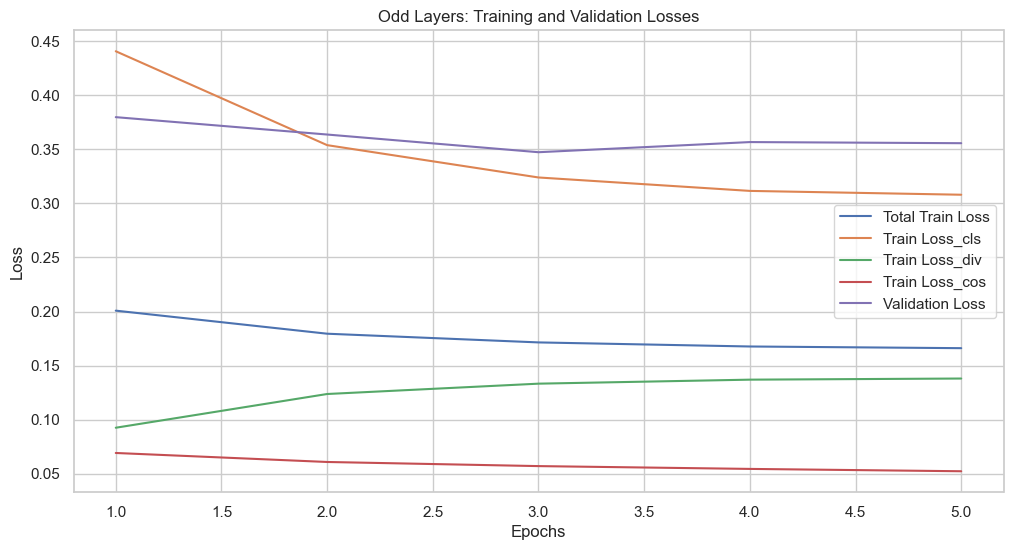

In [110]:
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_odd, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_odd, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_odd, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_odd, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_odd, label='Validation Loss')

plt.title('Odd Layers: Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 9.3 Testing and Inference

In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

### 9.3.1 Even layered model

In [112]:
y_true_even = []
y_pred_even = []

for batch in test_dataloader:
    input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    with torch.no_grad():
        # Forward pass
        outputs = model_even(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # Convert logits to predicted labels
        batch_predictions = torch.argmax(logits, dim=1)
        # Append true and predicted labels to lists
        y_true_even.extend(labels.cpu().numpy())
        y_pred_even.extend(batch_predictions.cpu().numpy())
# Compute evaluation metrics
accuracy_even = accuracy_score(y_true_even, y_pred_even)
precision_even = precision_score(y_true_even, y_pred_even, average='weighted')
recall_even = recall_score(y_true_even, y_pred_even, average='weighted')
f1_even = f1_score(y_true_even, y_pred_even, average='weighted')

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class ConfusionMatrixPlotter:
    def __init__(self, true_labels, predicted_labels, labels):
        self.true_labels = true_labels
        self.predicted_labels = predicted_labels
        self.labels = labels
    def plot(self):
        cm = confusion_matrix(self.true_labels, self.predicted_labels)
        plt.figure(figsize=(15, 5))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.labels, yticklabels=self.labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

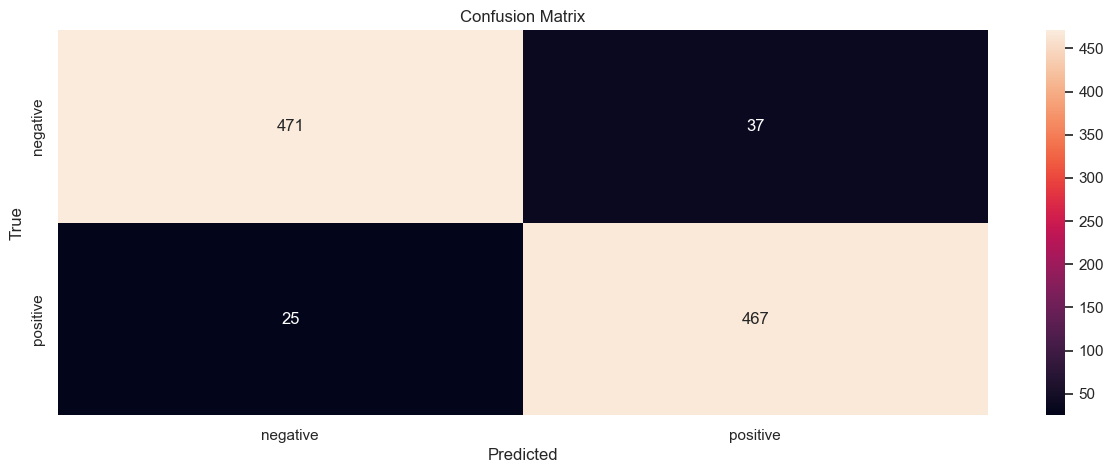

In [114]:
labels = ["negative", "positive"]
cm_plotter = ConfusionMatrixPlotter(y_true_even, y_pred_even, labels)
cm_plotter.plot()

In [115]:
print(f"Accuracy: {accuracy_even:.4f}")
print(f"Precision: {precision_even:.4f}")
print(f"Recall: {recall_even:.4f}")
print(f"F1: {f1_even:.4f}")

Accuracy: 0.9380
Precision: 0.9383
Recall: 0.9380
F1: 0.9380


In [116]:
print(classification_report(y_true_even, y_pred_even, target_names=labels))

              precision    recall  f1-score   support

    negative       0.95      0.93      0.94       508
    positive       0.93      0.95      0.94       492

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [117]:
model_even.eval()

text = ["I love you", "I hate you"]

inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

with torch.no_grad():
    outputs = model_even(input_ids.to(device), attention_mask=attention_mask.to(device))

predictions = torch.argmax(outputs.logits, dim=1)

for i, pred in enumerate(predictions):
    print(f"Text: {text[i]}")
    print(f"Predicted Label: {id2label[pred.item()]}\n")

Text: I love you
Predicted Label: non_toxic

Text: I hate you
Predicted Label: toxic



### 9.3.2 Odd layered model

In [118]:
y_true_odd = []
y_pred_odd = []

for batch in test_dataloader:
    input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    with torch.no_grad():
        # Forward pass
        outputs = model_odd(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # Convert logits to predicted labels
        batch_predictions = torch.argmax(logits, dim=1)
        # Append true and predicted labels to lists
        y_true_odd.extend(labels.cpu().numpy())
        y_pred_odd.extend(batch_predictions.cpu().numpy())
# Compute evaluation metrics
accuracy_odd = accuracy_score(y_true_odd, y_pred_odd)
precision_odd = precision_score(y_true_odd, y_pred_odd, average='weighted')
recall_odd = recall_score(y_true_odd, y_pred_odd, average='weighted')
f1_odd = f1_score(y_true_odd, y_pred_odd, average='weighted')

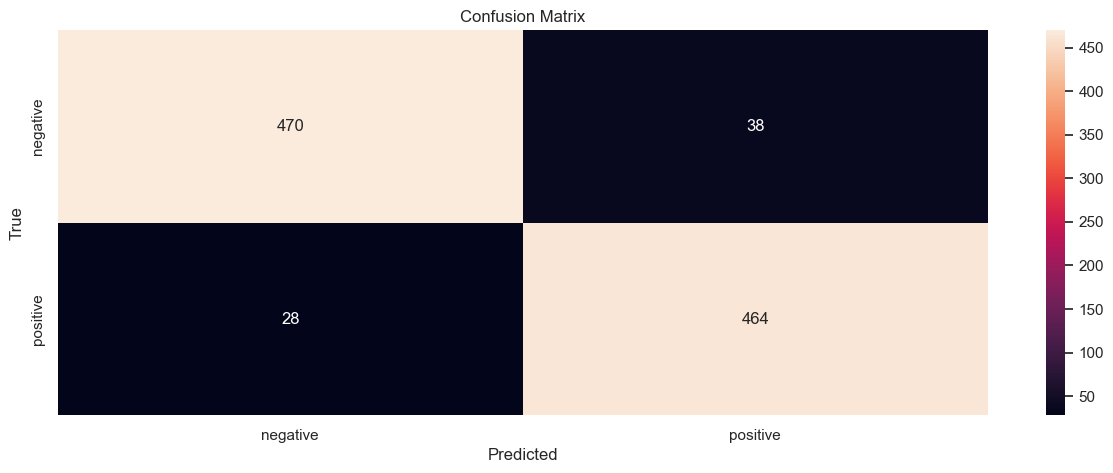

In [119]:
labels = ["negative", "positive"]
cm_plotter = ConfusionMatrixPlotter(y_true_odd, y_pred_odd, labels)
cm_plotter.plot()

In [120]:
print(f"Accuracy: {accuracy_odd:.4f}")
print(f"Precision: {precision_odd:.4f}")
print(f"Recall: {recall_odd:.4f}")
print(f"F1: {f1_odd:.4f}")

Accuracy: 0.9340
Precision: 0.9342
Recall: 0.9340
F1: 0.9340


In [121]:
print(classification_report(y_true_odd, y_pred_odd, target_names=labels))

              precision    recall  f1-score   support

    negative       0.94      0.93      0.93       508
    positive       0.92      0.94      0.93       492

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [67]:
model_odd.eval()

text = ["I love you", "I hate you"]

inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

with torch.no_grad():
    outputs = model_odd(input_ids.to(device), attention_mask=attention_mask.to(device))

predictions = torch.argmax(outputs.logits, dim=1)

for i, pred in enumerate(predictions):
    print(f"Text: {text[i]}")
    print(f"Predicted Label: {id2label[pred.item()]}\n")

Text: I love you
Predicted Label: non_toxic

Text: I hate you
Predicted Label: toxic



## 10. Saving the models

In [68]:
save_directory = "./model/trained_odd_model"

# Save the model
model_odd.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

save_directory = "./model/trained_even_model"
model_even.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./model/trained_even_model\\tokenizer_config.json',
 './model/trained_even_model\\special_tokens_map.json',
 './model/trained_even_model\\vocab.txt',
 './model/trained_even_model\\added_tokens.json',
 './model/trained_even_model\\tokenizer.json')

In [70]:
# teacher model

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss 
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler_even.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    
    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)
    
        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

 20%|█▉        | 312/1565 [01:35<06:23,  3.26it/s]

Epoch at 1: Train loss 0.2232:
Epoch at 1: Test Acc 0.9460


 40%|███▉      | 625/1565 [03:14<04:48,  3.26it/s]

Epoch at 2: Train loss 0.0866:
Epoch at 2: Test Acc 0.9360


 60%|█████▉    | 938/1565 [04:53<03:13,  3.25it/s]

Epoch at 3: Train loss 0.0487:
Epoch at 3: Test Acc 0.9440


 80%|███████▉  | 1251/1565 [06:33<01:36,  3.25it/s]

Epoch at 4: Train loss 0.0311:
Epoch at 4: Test Acc 0.9330


100%|█████████▉| 1564/1565 [08:12<00:00,  3.26it/s]

Epoch at 5: Train loss 0.0145:
Epoch at 5: Test Acc 0.9350
Avg Metric 0.9388000000000002


# 11. LoRA

In [46]:
from peft import LoraConfig, TaskType, get_peft_model

In [47]:
student_model_twelve = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = NUM_LABELS,
    id2label = id2label,
    label2id = label2id,
)
student_model_twelve

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [48]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    inference_mode=False, 
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "key", "value"]
)
student_model_twelve = get_peft_model(student_model_twelve, peft_config)

In [49]:
def compute_metrics(eval_preds):
    """
    Compute accuracy and other metrics for evaluation.

    Args:
    eval_preds: A tuple (predictions, labels) where:
        - predictions: model's predictions (logits or class probabilities)
        - labels: ground truth labels

    Returns:
    A dictionary with the evaluation metric(s).
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)  # Get class predictions from logits

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # You can add more metrics here (e.g., F1, precision, recall)
    return {"accuracy": accuracy}

## 11.1 Training

In [50]:
from transformers import TrainingArguments, Trainer, default_data_collator

In [51]:
training_args = TrainingArguments(
    output_dir="student-lora",
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    max_steps=-1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    evaluation_strategy="steps", 
    save_strategy="steps",        
    save_steps=500,               
    eval_steps=500,              
    fp16=True
)

tokenized_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "token_type_ids", "label"])

trainer = Trainer(
    model=student_model_twelve,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

c:\Users\Bidhan\anaconda3\envs\nlp\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Bidhan\AppData\Local\Temp\ipykernel_3576\924317031.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [52]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 66948
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8369
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8369
    })
})

In [55]:
trainer.train()
trainer.save_model()
student_model_twelve.save_pretrained("student-lora")

Step,Training Loss,Validation Loss,Accuracy
500,0.175300,0.157777,0.942645
1000,0.175900,0.160550,0.942526
1500,0.164600,0.156753,0.945155
2000,0.177900,0.132719,0.947664
2500,0.159700,0.130501,0.949934
3000,0.150400,0.141768,0.949456
3500,0.147500,0.133109,0.952921
4000,0.143100,0.140009,0.951249
4500,0.130600,0.144917,0.954355
5000,0.121100,0.136183,0.955192


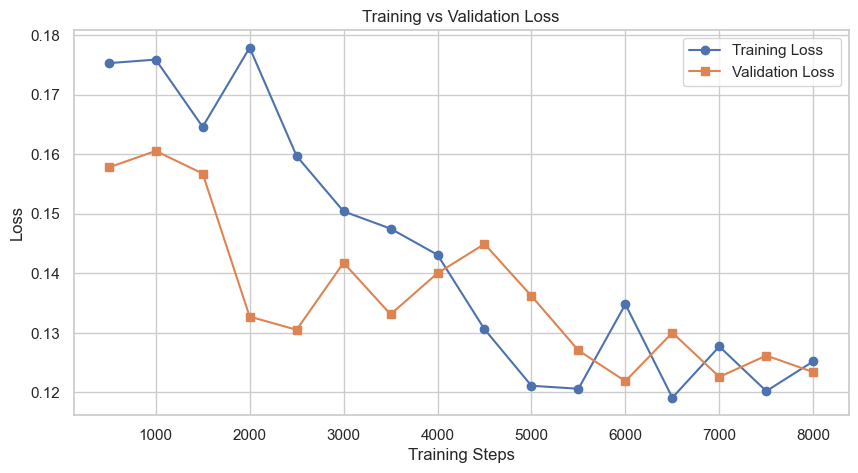

In [58]:
training_steps = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 
                  5500, 6000, 6500, 7000, 7500, 8000]
training_loss = [0.1753, 0.1759, 0.1646, 0.1779, 0.1597, 0.1504, 0.1475, 0.1431, 
                 0.1306, 0.1211, 0.1206, 0.1348, 0.1191, 0.1277, 0.1202, 0.1252]
validation_loss = [0.157777, 0.160550, 0.156753, 0.132719, 0.130501, 0.141768, 
                   0.133109, 0.140009, 0.144917, 0.136183, 0.127038, 0.121867, 
                   0.130018, 0.122593, 0.126177, 0.123396]

sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
plt.plot(training_steps, training_loss, label="Training Loss", marker="o")
plt.plot(training_steps, validation_loss, label="Validation Loss", marker="s")

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

## 11.2 Testing and Inference

In [ ]:
y_true_lora = []
y_pred_lora = []

for batch in test_dataloader:
    input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    with torch.no_grad():
        # Forward pass using the best lora model
        outputs = student_model_twelve(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # Convert logits to predicted labels
        batch_predictions = torch.argmax(logits, dim=1)
        # Append true and predicted labels to lists
        y_true_lora.extend(labels.cpu().numpy())
        y_pred_lora.extend(batch_predictions.cpu().numpy())
# Compute evaluation metrics
accuracy_lora = accuracy_score(y_true_lora, y_pred_lora)
precision_lora = precision_score(y_true_lora, y_pred_lora, average='weighted')
recall_lora = recall_score(y_true_lora, y_pred_lora, average='weighted')
f1_lora = f1_score(y_true_lora, y_pred_lora, average='weighted')

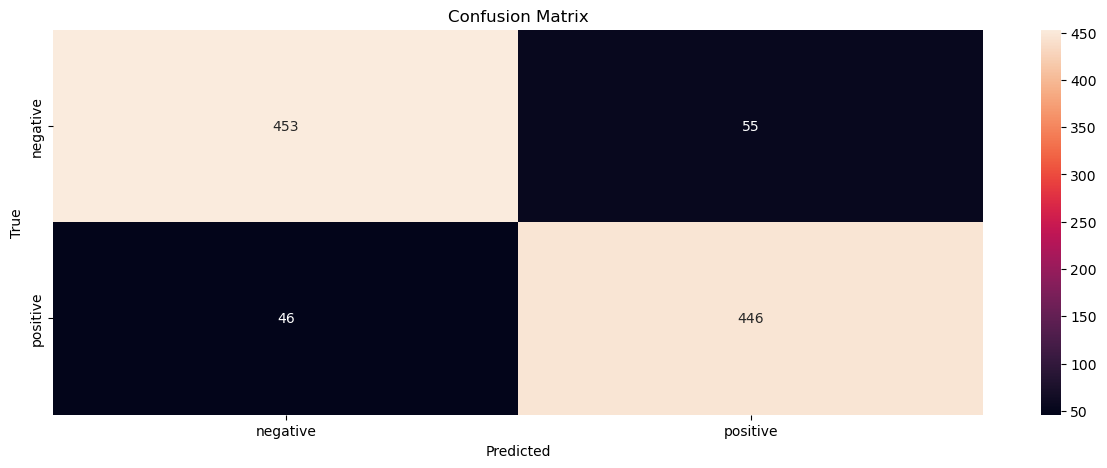

In [ ]:
labels = ["negative", "positive"]
cm_plotter = ConfusionMatrixPlotter(y_true_lora, y_pred_lora, labels)
cm_plotter.plot()

In [ ]:
print(f"Accuracy: {accuracy_lora:.4f}")
print(f"Precision: {precision_lora:.4f}")
print(f"Recall: {recall_lora:.4f}")
print(f"F1: {f1_lora:.4f}")

Accuracy: 0.8990
Precision: 0.8992
Recall: 0.8990
F1: 0.8990


In [ ]:
print(classification_report(y_true_lora, y_pred_lora, target_names=labels))

              precision    recall  f1-score   support

    negative       0.91      0.89      0.90       508
    positive       0.89      0.91      0.90       492

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



In [ ]:
student_model_twelve.eval()

text = ["I love you", "I hate you"]

inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

with torch.no_grad():
    outputs = student_model_twelve(input_ids.to(device), attention_mask=attention_mask.to(device))

predictions = torch.argmax(outputs.logits, dim=1)

for i, pred in enumerate(predictions):
    print(f"Text: {text[i]}")
    print(f"Predicted Label: {id2label[pred.item()]}\n")

Text: I love you
Predicted Label: non_toxic

Text: I hate you
Predicted Label: toxic



# 12. Evaluation and Analysis

## Even layered distilled BERT
For the even layered model scores were as such:
- Accuracy: 0.9380
- Precision: 0.9383
- Recall: 0.9380
- F1: 0.9380

It shows good overall performance. The classification report indicates a balanced performance, with precision and recall both close to 94%. The model performed slightly better on the negative class (precision of 0.95), but still maintained strong recall for both classes. We further see from confusion matrix that it achieved:
- TN: 471
- TP: 467
- FP: 37
- FN: 25

## Odd layered distilled BERT
Moving on to odd layered model, the scores were as such:
- Accuracy: 0.9340
- Precision: 0.9342
- Recall: 0.9340
- F1: 0.9340

It also shows good overall performance, but even layer out-performed it. The classification report shows that the model had a lower precision (0.92 for positive samples), meaning it made more false positives compared to the even-layered model. However, its recall for the positive class (0.94) was better than its precision, showing it was able to capture more positive instances. We further see from confusion matrix that it achieved:
- TN: 470
- TP: 464
- FP: 38
- FN: 28

## LoRA (Low-Rank Adaptation)
Finally, after implementing LoRA to the 12-layer student model, the best model's scores achieved were as such:
- Accuracy: 0.8990
- Precision: 0.8992
- Recall: 0.8990
- F1: 0.8990

It showed good performance, but is less than both the even and odd layered models. The report showed that the precision for the negative class was 0.91, and recall was 0.89, meaning the model had a higher chance of making false negatives. We further see from confusion matrix that it achieved:
- TN: 453
- TP: 446
- FP: 55
- FN: 46

So, the best model among all three was the even-layered distilled BERT model as it out-performed all the models in terms of accuracy, precision, recall, and F1 score.

## Observation

| Model Type   | Training Loss (Final Epoch) | Accuracy | Precision | Recall | F1 Score |
|--------------|---------------|----------|-----------|--------|----------|
| Odd Layer    | 0.1661 | 93.40%   | 93.42%    | 93.40% | 93.40%   |
| Even Layer   | 0.1657 | 93.80%   | 93.83%    | 93.80% | 93.80%   |
| LoRA         | 0.1252 | 89.90%   | 89.92%    | 89.90% | 89.90%   |


**Discussion of Challenges**

**Implementation**

In terms of implementation, the odd and even layer distillation required careful layer-wise mapping from the teacher model. But this challenge was tackled easily due to the reference code provided.

**Training**

In terms of training and resource usage, LoRA was more memory efficient as only adapter parameters were updated but for distillation it's slower because multiple layers have to be distilled seperately. So, to improve distillation efficiency - distillation of only the key layers can be done and also gradient checkpoint can also be applied to reduce the memory consumption and speed up the training.

For both the odd and even layered distillation, following training and validation performance were observed:
- Total Train Loss is Decreasing: This indicates that the model is learning and optimizing during training.

- Classification Loss `(Train Loss_cls)` is Steadily Decreasing: This is a positive sign, as the model is improving its classification ability. However, it flattens in later epochs, indicating that learning is slowing down.

- Divergence Loss `(Train Loss_div)` is Increasing: This could indicate that the student model is struggling to match the teacher model’s representations, which might affect generalization.

- Cosine Similarity Loss `(Train Loss_cos)` is Decreasing: This suggests that the model is gradually aligning its representation with the teacher model.

- Validation Loss is Stagnating and Slightly Increasing: This is a critical. Even though the training loss is decreasing, the validation loss is not improving and is instead slightly increasing, which is a sign of overfitting.

For improvement following techniques can be applied:
- Apply regularization techniques
- Apply early stopping to prevent overfitting
- Since, student model is not effictively mimicking the teacher model, we can reduce the weight of divergence loss or gradually introduce it after a few epochs
- Can apply learning rate scheduler to help prevent performance degradation

LoRA performed well during the training. The training and validaiton loss gradually decreased with slight fluctuation - but we can see an overall decreasing trend. Which suggests that our model is generalizing well.